<a href="https://colab.research.google.com/github/Mon82sj/VOIS/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
#FINAL CODE
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
df = pd.read_csv('student_domain_course_ratings.csv')

# Rename 'Ratings' to 'Rating'
df.rename(columns={'Ratings': 'Rating'}, inplace=True)

# Normalize case
df['Domain'] = df['Domain'].str.lower()
df['Course'] = df['Course'].str.lower()

# Combine 'Domain' and 'Course' columns into a single 'content' column for TF-IDF
df['content'] = df['Domain'] + " " + df['Course']

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the content to generate the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df['content'])

# Calculate the cosine similarity between all courses
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a series with the course names as the index, handling duplicates
course_indices = pd.Series(df.index, index=df['Course']).drop_duplicates()

def recommend_courses(search_input, cosine_sim=cosine_sim):
    search_input = search_input.lower()  # Normalize user input case

    if search_input in course_indices.index:
        # User input is a course
        idx_list = course_indices[search_input]

        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])

        # Use the first index in case of multiple entries
        idx = idx_list[0]
        course_domain = df.at[idx, 'Domain']

        # List courses in the same domain
        domain_courses = df[df['Domain'] == course_domain]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    elif search_input in df['Domain'].values:
        # User input is a domain
        domain_courses = df[df['Domain'] == search_input]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Example: Recommend courses based on user input
user_input = input("Enter the course name : ")  # Replace with dynamic user input if needed
recommended_courses_df = recommend_courses(user_input)
print("Recommended courses:")
print(recommended_courses_df)


Enter the course name : cloud computing
Recommended courses:
                Course  Rating
67      cloud security       5
72      cloud security       5
46  azure fundamentals       4
16      aws essentials       3
26      aws essentials       3
33      aws essentials       2
56        cloud basics       2
1         cloud basics       0
3       cloud security       0
13        cloud basics       0
29        cloud basics       0
94      aws essentials       0
96        cloud basics       0


In [ ]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357281 sha256=670f23fb06abd0db3de93acb188e80a387b4daf29ce9d1c26145d95ed5045255
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [168]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
import pandas as pd

# Load your dataset
df = pd.read_csv('student_domain_course_ratings.csv')

# Define a Reader for surprise
reader = Reader(rating_scale=(df['Rating'].min(), df['Rating'].max()))

# Load the dataset into Surprise
data = Dataset.load_from_df(df[['Student ID', 'Course', 'Rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Initialize and train the SVD model
model = SVD()
model.fit(trainset)

# Evaluate the model
predictions = model.test(testset)
accuracy = accuracy.rmse(predictions)
print(f'RMSE: {accuracy}')

# Cross-Validation
cv_results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)


RMSE: 1.7400
RMSE: 1.7399713883415797
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7654  1.7904  1.6016  1.3320  1.8674  1.6714  0.1905  
Fit time          0.00    0.00    0.01    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [183]:
# Complete preprocessing pipeline
df = pd.read_csv('student_domain_course_ratings.csv')

# Handle missing values
df['Domain'].fillna('unknown', inplace=True)
df['Course'].fillna('unknown', inplace=True)
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

# Remove duplicates
df.drop_duplicates(subset=['Student ID', 'Course'], keep='last', inplace=True)

# Filter outliers
Q1 = df['Rating'].quantile(0.25)
Q3 = df['Rating'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Rating'] >= (Q1 - 1.5 * IQR)) & (df['Rating'] <= (Q3 + 1.5 * IQR))]

# Feature engineering
df['Course_Length'] = df['Course'].apply(len)

# Standardize ratings
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['Rating'] = scaler.fit_transform(df[['Rating']])

# Advanced text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stemmer = PorterStemmer()

def stem_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

df['Domain'] = df['Domain'].apply(lambda x: stem_words(x))

tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = tfidf.fit_transform(df['Domain'])


df['Course'] = df['Course'].apply(lambda x: stem_words(x))

tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = tfidf.fit_transform(df['Course'])
# Continue with the rest of your recommendation system code

# Filter items and users with very few ratings
min_ratings = 5  # Set a threshold for minimum number of ratings
ratings_counts = df.groupby('Course').size()
valid_courses = ratings_counts[ratings_counts >= min_ratings].index

df_filtered = df[df['Course'].isin(valid_courses)]
data_filtered = Dataset.load_from_df(df_filtered[['Student ID', 'Course', 'Rating']], reader)

# Split the filtered dataset into training and testing sets
trainset, testset = train_test_split(data_filtered, test_size=0.2, random_state=42)


print(df.head())

#FINAL CODE
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
df = pd.read_csv('student_domain_course_ratings.csv')

# Rename 'Ratings' to 'Rating'
df.rename(columns={'Ratings': 'Rating'}, inplace=True)

# Normalize case
df['Domain'] = df['Domain'].str.lower()
df['Course'] = df['Course'].str.lower()

# Combine 'Domain' and 'Course' columns into a single 'content' column for TF-IDF
df['content'] = df['Domain'] + " " + df['Course']

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the content to generate the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df['content'])

# Calculate the cosine similarity between all courses
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a series with the course names as the index, handling duplicates
course_indices = pd.Series(df.index, index=df['Course']).drop_duplicates()

def recommend_courses(search_input, cosine_sim=cosine_sim):
    search_input = search_input.lower()  # Normalize user input case

    if search_input in course_indices.index:
        # User input is a course
        idx_list = course_indices[search_input]

        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])

        # Use the first index in case of multiple entries
        idx = idx_list[0]
        course_domain = df.at[idx, 'Domain']

        # List courses in the same domain
        domain_courses = df[df['Domain'] == course_domain]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    elif search_input in df['Domain'].values:
        # User input is a domain
        domain_courses = df[df['Domain'] == search_input]

        # Sort courses by rating
        domain_courses_sorted = domain_courses.sort_values(by='Rating', ascending=False).head(20)
        return domain_courses_sorted[['Course', 'Rating']]

    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Example: Recommend courses based on user input
user_input = input("Enter the course name : ")  # Replace with dynamic user input if needed
recommended_courses_df = recommend_courses(user_input)
print("Recommended courses:")
print(recommended_courses_df)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Student ID        Domain              Course    Rating  Course_Length
0  Student_1  machin learn  machin learn basic -1.366809             23
1  Student_2  cloud comput         cloud basic -1.366809             12
2  Student_3    cybersecur        cryptographi -1.366809             12
3  Student_4  cloud comput         cloud secur -1.366809             14
4  Student_5    cybersecur          ethic hack -1.366809             15
Enter the course name : aws essentials
Recommended courses:
                Course  Rating
67      cloud security       5
72      cloud security       5
46  azure fundamentals       4
16      aws essentials       3
26      aws essentials       3
33      aws essentials       2
56        cloud basics       2
1         cloud basics       0
3       cloud security       0
13        cloud basics       0
29        cloud basics       0
94      aws essentials       0
96        cloud basics       0


<ipython-input-183-fdecf46af12b>:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  idx = idx_list[0]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


RMSE: 0.8974
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9241
SVD RMSE: 0.8974015046447884
KNN RMSE: 0.9241349096697583
Enter the course name : cloud computing
Input not found.
No content-based recommendations found. Trying collaborative filtering...
Recommended courses:
Empty DataFrame
Columns: [Course, Rating]
Index: []
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1511  0.9292  0.9352  0.9667  0.8956  0.9756  0.0906  
MAE (testset)     1.0185  0.8274  0.7928  0.8809  0.7762  0.8592  0.0873  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pear

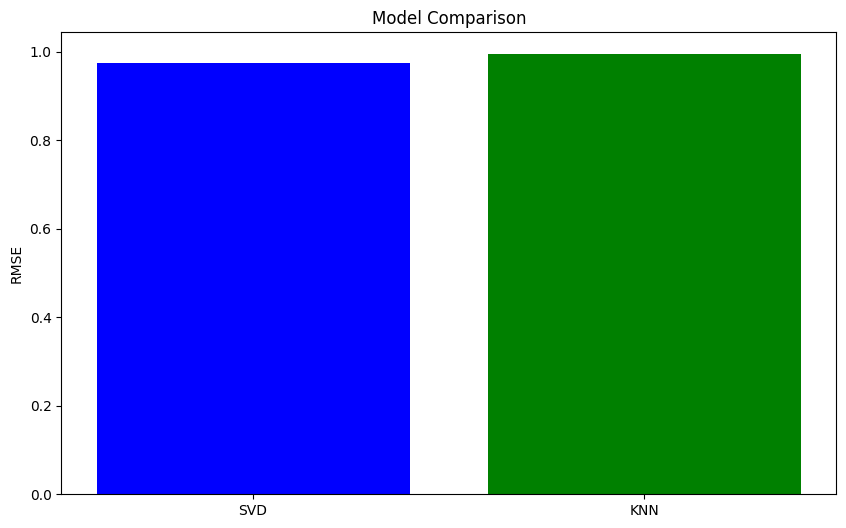

In [184]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
import matplotlib.pyplot as plt
import nltk

# Load and preprocess data
df = pd.read_csv('student_domain_course_ratings.csv')

# Handle missing values
df['Domain'].fillna('unknown', inplace=True)
df['Course'].fillna('unknown', inplace=True)
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

# Remove duplicates
df.drop_duplicates(subset=['Student ID', 'Course'], keep='last', inplace=True)

# Filter outliers
Q1 = df['Rating'].quantile(0.25)
Q3 = df['Rating'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Rating'] >= (Q1 - 1.5 * IQR)) & (df['Rating'] <= (Q3 + 1.5 * IQR))]

# Feature engineering and standardization
df['Course_Length'] = df['Course'].apply(len)
scaler = StandardScaler()
df['Rating'] = scaler.fit_transform(df[['Rating']])

# Advanced text processing
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

stemmer = PorterStemmer()

def stem_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

df['Domain'] = df['Domain'].apply(lambda x: stem_words(x))
df['Course'] = df['Course'].apply(lambda x: stem_words(x))

# Content-Based Filtering
df['content'] = df['Domain'] + " " + df['Course']
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = tfidf.fit_transform(df['content'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
course_indices = pd.Series(df.index, index=df['Course']).drop_duplicates()

def recommend_courses_content_based(search_input, cosine_sim=cosine_sim, course_indices=course_indices):
    search_input = search_input.lower()
    if search_input in course_indices.index:
        idx_list = course_indices[search_input]
        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])
        idx = idx_list[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:21]
        course_indices = [i[0] for i in sim_scores]
        recommended_courses = df.iloc[course_indices]
        return recommended_courses[['Course', 'Rating']]
    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Collaborative Filtering
reader = Reader(rating_scale=(df['Rating'].min(), df['Rating'].max()))
data = Dataset.load_from_df(df[['Student ID', 'Course', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define and train models
svd = SVD()
svd.fit(trainset)
svd_predictions = svd.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)

sim_options = {
    'name': 'pearson_baseline',
    'user_based': False
}
knn = KNNBasic(k=10, min_k=5, sim_options=sim_options)
knn.fit(trainset)
knn_predictions = knn.test(testset)
knn_rmse = accuracy.rmse(knn_predictions)

print(f"SVD RMSE: {svd_rmse}")
print(f"KNN RMSE: {knn_rmse}")

# Combine recommendations
def recommend_courses_combined(search_input):
    content_based_recs = recommend_courses_content_based(search_input)
    if content_based_recs.empty:
        print("No content-based recommendations found. Trying collaborative filtering...")
        # Collaborative filtering logic can be added here if needed
        # For now, returning an empty DataFrame
        return pd.DataFrame(columns=['Course', 'Rating'])
    return content_based_recs

# Example usage
user_input = input("Enter the course name : ")  # Replace with dynamic user input if needed
recommended_courses_df = recommend_courses_combined(user_input)
print("Recommended courses:")
print(recommended_courses_df)

# Compare models (optional)
cv_results_svd = cross_validate(svd, data, cv=5, verbose=True)
cv_results_knn = cross_validate(knn, data, cv=5, verbose=True)

models = ['SVD', 'KNN']
rmse_results = [cv_results_svd['test_rmse'].mean(), cv_results_knn['test_rmse'].mean()]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_results, color=['blue', 'green'])
plt.ylabel('RMSE')
plt.title('Model Comparison')
plt.show()


In [190]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def load_and_prepare_data(file_path):
    """Load dataset and prepare it for processing."""
    df = pd.read_csv(file_path)
    df.rename(columns={'Ratings': 'Rating'}, inplace=True)
    df['Domain'] = df['Domain'].str.lower()
    df['Course'] = df['Course'].str.lower()
    df['content'] = df['Domain'] + " " + df['Course']
    return df

def compute_tfidf_matrix(df):
    """Compute TF-IDF matrix from the 'content' column."""
    tfidf = TfidfVectorizer(stop_words='english')
    return tfidf.fit_transform(df['content'])

def calculate_cosine_similarity(tfidf_matrix):
    """Calculate cosine similarity matrix."""
    return cosine_similarity(tfidf_matrix, tfidf_matrix)

def create_course_index(df):
    """Create a Series with the course names as the index."""
    return pd.Series(df.index, index=df['Course']).drop_duplicates()

def get_domain_courses(df, domain):
    """Get courses for a given domain and sort by rating."""
    domain_courses = df[df['Domain'] == domain]
    return domain_courses.sort_values(by='Rating', ascending=False).head(20)[['Course', 'Rating']]

def recommend_courses(search_input, df, cosine_sim, course_indices):
    """Recommend courses based on user input."""
    search_input = search_input.lower()
    if search_input in course_indices.index:
        idx_list = course_indices[search_input]
        if len(idx_list) == 0:
            print("Course not found.")
            return pd.DataFrame(columns=['Course', 'Rating'])
        idx = idx_list[0]
        course_domain = df.at[idx, 'Domain']
        return get_domain_courses(df, course_domain)
    elif search_input in df['Domain'].values:
        return get_domain_courses(df, search_input)
    else:
        print("Input not found.")
        return pd.DataFrame(columns=['Course', 'Rating'])

# Main execution
if __name__ == "__main__":
    df = load_and_prepare_data('student_domain_course_ratings.csv')
    tfidf_matrix = compute_tfidf_matrix(df)
    cosine_sim = calculate_cosine_similarity(tfidf_matrix)
    course_indices = create_course_index(df)

    user_input = input("Enter the course name or domain: ")  # Replace with dynamic user input if needed
    recommended_courses_df = recommend_courses(user_input, df, cosine_sim, course_indices)
    print("Recommended courses:")
    print(recommended_courses_df)


Enter the course name or domain: machine learning
Recommended courses:
                         Course  Rating
14      machine learning basics       5
86      machine learning basics       5
69                deep learning       5
83  natural language processing       4
70              neural networks       4
98  natural language processing       3
79      machine learning basics       3
6       machine learning basics       3
17              neural networks       3
76  natural language processing       3
97      machine learning basics       2
37  natural language processing       1
5                 deep learning       1
92                deep learning       0
81      machine learning basics       0
0       machine learning basics       0
47      machine learning basics       0
45                deep learning       0
35                deep learning       0
28      machine learning basics       0
